https://youtu.be/oBIkr7CAE6g

In [1]:
import tensorflow as tf
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob

In [2]:
image_directory = 'data/training/images'
gt_directory = 'data/training/groundtruth'
SIZE = 608

In [3]:
# store train RGB images
image_names = glob.glob(image_directory + '/*.png')
#images = [cv2.imread(img) for img in image_names]
images = [cv2.resize(cv2.imread(img),(SIZE,SIZE)) for img in image_names]
image_dataset = np.array(images)


In [4]:
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
#gt = [cv2.imread(gt,0) for gt in gt_names]
gt = [cv2.resize(cv2.imread(gt,0),(SIZE,SIZE)) for gt in gt_names]
gt_dataset = np.array(gt)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [5]:
print("Image data shape is: ", image_dataset.shape)
print("gt data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset))

Image data shape is:  (100, 608, 608, 3)
gt data shape is:  (100, 608, 608, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 2

In [6]:
# binary labels
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
# resize and define binary threshold
gt_dataset = []
for gt in gt_names:
    gt_img = cv2.imread(gt,0)
    gt_img = cv2.resize(gt_img,(SIZE,SIZE))
    _,gt_img = cv2.threshold(gt_img, 120, 255, cv2.THRESH_BINARY)
    gt_dataset.append(gt_img)

gt_dataset = np.array(gt_dataset)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [7]:
print("Image data shape is: ", image_dataset.shape)
print("get data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset))

Image data shape is:  (100, 608, 608, 3)
get data shape is:  (100, 608, 608, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0 255]


In [8]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
gt_dataset = gt_dataset /255.  #PIxel values will be 0 or 1

In [9]:
road = np.sum(gt_dataset == 1,axis=(0,1,2))
back = np.sum(gt_dataset == 0,axis=(0,1,2))
road/(back+road)[0]

array([0.20084239])

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, gt_dataset, test_size = 0.20,random_state=43)



In [11]:
def flip_and_rotate(image_dataset, gt_dataset):

    image_dataset_90 = np.rot90(image_dataset, axes=(1,2), k=1)
    gt_dataset_90 = np.rot90(gt_dataset, axes=(1,2), k=1)

    image_dataset_180 = np.rot90(image_dataset, axes=(1,2), k=2)
    gt_dataset_180 = np.rot90(gt_dataset, axes=(1,2), k=2)

    image_dataset_270 = np.rot90(image_dataset, axes=(1,2), k=3)
    gt_dataset_270 = np.rot90(gt_dataset, axes=(1,2), k=3)

    image_dataset_ver = np.flip(image_dataset, axis=1)
    gt_dataset_ver = np.flip(gt_dataset, axis=1)

    image_dataset_hor = np.flip(image_dataset, axis=2)
    gt_dataset_hor = np.flip(gt_dataset, axis=2)

    aug_image_dataset = np.concatenate((image_dataset_90, image_dataset_180, image_dataset_270, image_dataset_ver, image_dataset_hor), axis=0)
    aug_gt_dataset = np.concatenate((gt_dataset_90, gt_dataset_180, gt_dataset_270, gt_dataset_ver, gt_dataset_hor), axis=0)
    
    return aug_image_dataset, aug_gt_dataset

In [49]:
def histogram_equalization(img_in):
    # segregate color streams
    b,g,r = cv2.split((img_in*255).astype('uint8'))
    h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
    h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
    h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
    # calculate cdf    
    cdf_b = np.cumsum(h_b)  
    cdf_g = np.cumsum(h_g)
    cdf_r = np.cumsum(h_r)

    # mask all pixels with value=0 and replace it with mean of the pixel values 
    cdf_m_b = np.ma.masked_equal(cdf_b,0)
    cdf_m_b = (cdf_m_b - cdf_m_b.min())*255/(cdf_m_b.max()-cdf_m_b.min())
    cdf_final_b = np.ma.filled(cdf_m_b,0).astype('uint8')

    cdf_m_g = np.ma.masked_equal(cdf_g,0)
    cdf_m_g = (cdf_m_g - cdf_m_g.min())*255/(cdf_m_g.max()-cdf_m_g.min())
    cdf_final_g = np.ma.filled(cdf_m_g,0).astype('uint8')
    cdf_m_r = np.ma.masked_equal(cdf_r,0)
    cdf_m_r = (cdf_m_r - cdf_m_r.min())*255/(cdf_m_r.max()-cdf_m_r.min())
    cdf_final_r = np.ma.filled(cdf_m_r,0).astype('uint8')
    # merge the images in the three channels
    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]

    img_out = cv2.merge((img_b, img_g, img_r))
    # validation
    equ_b = cv2.equalizeHist(b)
    equ_g = cv2.equalizeHist(g)
    equ_r = cv2.equalizeHist(r)
    equ = cv2.merge((equ_b, equ_g, equ_r))
    #print(equ)
    #cv2.imwrite('output_name.png', equ)
    return img_out

In [47]:
X_train[image_number].shape
b,g,r = cv2.split(X_train[image_number]*255)
b

array([[ 82.,  84.,  86., ..., 221., 221., 222.],
       [ 82.,  85.,  88., ..., 223., 224., 225.],
       [ 84.,  86.,  88., ..., 225., 227., 228.],
       ...,
       [ 47.,  53.,  59., ...,  58.,  43.,  35.],
       [ 53.,  54.,  55., ...,  59.,  52.,  50.],
       [ 59.,  55.,  51., ...,  63.,  66.,  71.]])

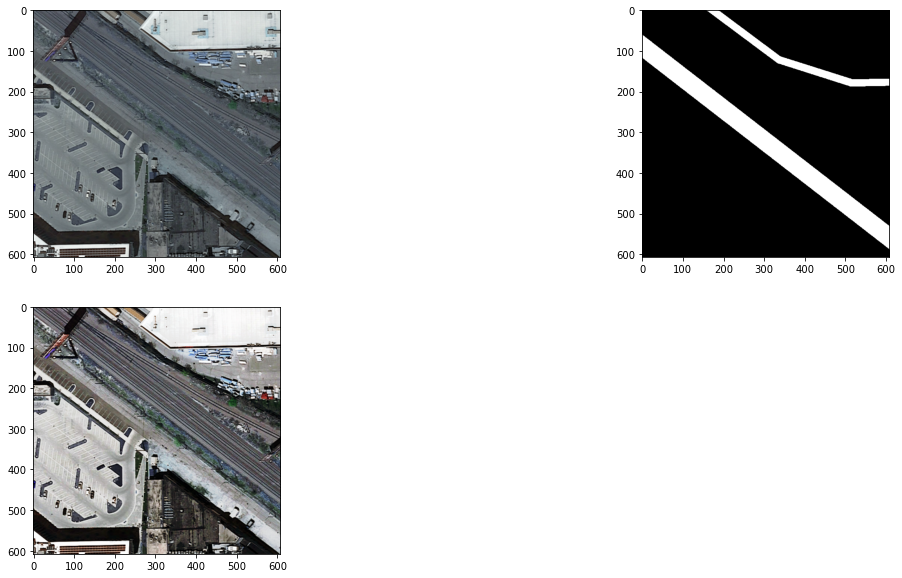

In [56]:
#Sanity check
import random


image_number = random.randint(0, len(X_train)-1)
hist=histogram_equalization(X_train[image_number])
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.imshow(X_train[image_number],cmap='GnBu_r')
plt.subplot(222)
plt.imshow(y_train[image_number], cmap='gray')
plt.subplot(223)
plt.imshow(hist,cmap='GnBu_r')


(608, 608, 3)

In [13]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [14]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
import tensorflow.compat.v1.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

## KUC model

In [16]:

import segmentation_models as sm

import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [17]:
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)


In [18]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet',classes=1,activation='sigmoid')

In [19]:
#checkpoint_filename = 'best_r2unet.h5'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    #filepath=checkpoint_filepath,
    #save_weights_only=False,
    #monitor='val_f1_m',
    #mode='max',
    #save_best_only=True)
Early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('best_unet_bceDICE_resnet18_batch16.h5', monitor='val_f1_m', mode='max', save_best_only=True)

In [20]:
# wandb.config = {
#   "learning_rate": 0.0001,
#   "epochs": 50,
#   "batch_size": 4
# }

model.compile(optimizer=Adam(learning_rate = 0.0001), loss=sm.losses.DiceLoss(), metrics=['accuracy',f1_m] )


absl-py==1.0.0
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client @ file:///C:/ci/anaconda-client_1635342725944/work
anaconda-navigator==2.1.1
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1626085644852/work
anyio @ file:///C:/ci/anyio_1620153135622/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037869401/work
arrow @ file:///C:/ci/arrow_1617738834352/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1628063282661/work
astropy @ file:///C:/ci/astropy_1629829318700/work
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1620827162558/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1620866417880/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.func

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
# create data generator
datagen = ImageDataGenerator(horizontal_flip=True,rotation_range=45,brightness_range=[0.2,1.0],zoom_range=[0.5,1.0])

In [28]:
# create iterator
it = datagen.flow(X_train, y_train)

In [29]:
fit = model.fit(it, steps_per_epoch=10, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    )


Epoch 1/50


KeyboardInterrupt: 

## post processing

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model('best_unet_bceDICE_resnet18_batch16.h5', compile=False)

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.25

In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0]  > 0.5).astype(np.uint8)

prediction_t = (model.predict(test_img_input)[0,:,:,0] > 0.5 ).astype(np.uint8)
prediction_t = prediction_t > 0.5

plt.figure(figsize=(16, 8))
plt.subplot(141)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(142)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(143)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
#plt.subplot(144)
#plt.title('Prediction on test image')
#plt.imshow(prediction_t, cmap='gray')
plt.show()

In [ ]:
# store test RGB images
test_names = glob.glob('data/test_set_images/*' + '/*.png')
test_names.sort()
test_images = [cv2.imread(img) for img in test_names]
final_testing_dataset = np.array(test_images)
final_testing_dataset = final_testing_dataset /255.

In [ ]:
final_testing_dataset = preprocess_input(X_test)

In [ ]:
test_img_number = random.randint(0, len(final_testing_dataset)-1)
test_img = final_testing_dataset[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5 ).astype(np.uint8)
print(prediction.shape)
prediction_t = (model.predict(test_img_input)[0,:,:,0] > 0.8).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(132)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(prediction_t, cmap='gray')

